In [1]:
import torch
import numpy as np
import scipy as sc
import scipy.signal
import matplotlib.pyplot as plt
import random
import h5py
import torch.nn as nn
import warnings
import time
import copy
import torch.optim as optim

from datetime import datetime
from itertools import permutations
from torch.autograd import Variable
from tqdm import tqdm
from torch.optim import lr_scheduler
from sklearn.model_selection import train_test_split
warnings.simplefilter("ignore")
plt.close('all')
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

In [2]:
def Set_Overall_Seed(SeedNumber = 42):
  random.seed(SeedNumber)
  np.random.seed(SeedNumber)
  torch.manual_seed(SeedNumber)
Set_Overall_Seed()

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [4]:
# Main_Foldar = r"/content/drive/MyDrive/ModelBasedDeepLearning/FinalProject"
Main_Foldar = r"/content/drive/MyDrive/Code/Python/ulrasound_beamforming"

## System Model

In [5]:
class System_model(object):
    def __init__(self, scenario, N, M, DOA= None, freq_values = None):
        self.scenario = scenario                                    # Narrowband or Broadband
        self.N = N                                                  # Number of sensors in element
        self.M = M                                                  # Number of sources
        self.Scenario_define(freq_values)                           # Define parameters    
        self.Create_array()                                         # Define array indicies 
             
    def Scenario_define(self, freq_values):
        if self.scenario == "Broadband":
            ## frequencies initialization ##
            self.min_freq = freq_values[0]                          # Define minimal frequency value  
            self.max_freq = freq_values[1]                          # Define maximal frequency value  
            self.f_rng = np.linspace(start= self.min_freq,
                             stop= self.max_freq,
                              num= self.max_freq - self.min_freq,
                               endpoint = False)                    # Frequency range of interest  
            self.f_sampling = 2 * (self.max_freq)                   # Define sampling rate as twice the maximal frequency
            self.time_axis = np.linspace(0, 1, self.f_sampling,
                             endpoint = False)                      # Define time axis
            ## Array initialization ##
            self.dist = 1 / (2 * self.max_freq)                     # distance between array elements
        else: 
            ## frequencies initialization ##
            self.min_freq = None
            self.max_freq = None
            self.f_rng = None
            self.fs = None
            ## Array initialization ##
            self.dist = 1 / 2                                       # distance between array elements
 
    def Create_array(self):
        self.array = np.linspace(0, self.N, self.N, endpoint = False)   # create array of sensors locations
    
    def SV_Creation(self, theta, f = 1, Array_form = "ULA"):
        if self.scenario == "NarrowBand":
           f = 1
        if Array_form == "ULA":
            return np.exp(-2 * 1j * np.pi * f * self.dist * self.array * np.sin(theta))

    def __str__(self):
        print("System Model Summery:")
        for key,value in self.__dict__.items():
            print (key, " = " ,value)
        return "End of Model"

## Signal Creation

In [6]:
def CreateDOAwithGapM(M, gap):
  while(True):
    DOA = np.round(np.random.rand(M) * 180 ,decimals=2) - 90
    DOA.sort()
    diffbetweenAngles = np.array([np.abs(DOA[i+1] - DOA[i]) for i in range(M-1)])
    if(np.sum(diffbetweenAngles > gap) == M - 1 and np.sum(diffbetweenAngles < (180 - gap)) == M - 1):
      break
  return DOA

class Sampels(object):
    def __init__(self, System_model, DOA, observations):
        self.scenario = System_model.scenario
        self.N = System_model.N
        self.M = System_model.M
        self.T = observations
        self.SV_Creation = System_model.SV_Creation
        if DOA == None:
          # self.DOA = np.array(np.pi * (np.random.rand(self.M) - 0.5))         # generate aribitrary DOA angels
          self.DOA = (np.pi / 180) * np.array(CreateDOAwithGapM(M = self.M, gap = 5)) # (~0.08 rad)
            # self.DOA = np.array(np.round((np.pi * ((np.random.rand(self.M) - 0.5))),decimals=2))
        else: 
          self.DOA = (np.pi / 180) * np.array(DOA)                              # define DOA angels
    
    
    def Sampels_creation(self, mode, N_mean= 0, N_Var= 1, S_mean= 0, S_Var= 1, SNR= 10, Carriers= None):
        '''
        @mode = represent the specific mode in the specific scnarion
                e.g. "Broadband" scenarion in "non-coherent" mode
        '''
        signal = self.Signal_creation(mode, S_mean, S_Var, SNR, Carriers)
        noise = self.Noise_Creation(N_mean, N_Var)
        A = np.array([self.SV_Creation(theta) for theta in self.DOA]).T
        
        if self.scenario == "NarrowBand":
            sampels = (A @ signal) + noise 
            return sampels, signal, A, noise

        elif self.scenario == "Broadband":
            self.time_axis = System_model.time_axis
            samples = []
            SV = []
            self.f_sampling = System_model.f_sampling

            freq_axis = np.sort(-1 * np.linspace(-self.f_sampling // 2, -self.f_sampling // 2 , -self.f_sampling, endpoint=False))
            for idx,f in enumerate(freq_axis):
                A = np.array([self.SV_Creation(theta,f) for theta in self.DOA]).T
                samples.append((A @ signal[:, idx]) + noise[:, idx])
                SV.append(A)
            samples = np.array(samples)
            SV = np.array(SV)
            sampels_time_domain = np.fft.ifft(samples.T, axis=1)[:, :self.T]
            return sampels_time_domain, signal, SV, noise

    def Noise_Creation(self, N_mean, N_Var):
        if self.scenario == "NarrowBand":
            # for NarrowBand scenario Noise represented in the time domain
            return np.sqrt(N_Var) * (np.random.randn(self.N, self.T) + 1j * np.random.randn(self.N, self.T)) + N_mean
        elif self.scenario == "Broadband":
            # for Broadband scenario Noise represented in the frequency domain
            noise = (np.sqrt(2) / 2) * (np.random.randn(self.N, len(self.time_axis)) + 1j * np.random.randn(self.N, len(self.time_axis))) + N_mean
            return np.fft.fft(noise)
    
    def Signal_creation(self, mode, S_mean=0, S_Var=1, SNR= 10, Carriers= None):
        if self.scenario == "NarrowBand":
            f = 1
            # Amp = 20 * np.log10(SNR)
            Amp = (10 ** (SNR / 10))

            if mode == "non-coherent": 
            # create M non - coherent signals
                return Amp * np.sqrt(S_Var) * (np.random.randn(self.M, self.T) + 1j * np.random.randn(self.M, self.T)) + S_mean
        
            elif mode == "coherent": 
                # create coherent signal such that all signals are the same
                # and arrived from different angels
                sig = Amp * np.sqrt(S_Var) * (np.random.randn(1, self.T) + 1j * np.random.randn(1, self.T)) + S_mean
                return np.repeat(sig, self.M, axis = 0)
        
        if self.scenario == "Broadband":
            Amp = (np.sqrt(2) / 2 ) * 20 * np.log10(SNR) 
            # Amp = (10 ** (SNR / 10))
            sig = []
            if mode == "non-coherent":
                for f_c in Carriers:
                    Amp_f_c = Amp * (np.random.randn() + 1j * np.random.randn())
                    sig_fc = Amp_f_c * np.exp(2 * np.pi * 1j * f_c * self.time_axis)
                    sig.append(sig_fc)
                # for Broadband scenario Noise represented in the frequency domain
                return np.fft.fft(sig)
            ###### should be updated ######
            if mode == "OFDM": 
                pass
            if mode == "mod-OFDM": 
                pass
        else:
            return 0

## Methods

In [7]:
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt

class Model_Based_methods(object):
    def __init__(self,System_model):
        self.angels = np.linspace(-1 * np.pi / 2, np.pi / 2, 4, endpoint=False)                        # angle axis for represantation of the MUSIC spectrum
        self.system_model = System_model
        self.dist = System_model.dist
        self.M = System_model.M
        self.dist = System_model.dist

    def Basic_MVDR(self, X, TargetDOA):
        '''
        Implamentation of the Minimum Variance Beamformer algorithm
        in Narrowband scenario, without applying Spatial Smoothing

        Input:
        @ X = sampels vector shape : Nx1
        @ NUM_OF_SOURCES = indication flag for the knowladge of number of sources
        
        Output:
        @ 

        '''
        TargetDOA = (TargetDOA * np.pi) / 180
        eps = 1
        R_x = np.cov(X)
        R_eps = R_x + eps * np.identity(R_x.shape[0])
        # R_eps = R_x 
        a_sv = self.system_model.SV_Creation(theta = TargetDOA, f = 1, Array_form = "ULA")
        a_sv = a_sv.reshape(a_sv.shape[0], 1)
        
        # print("a_sv ", a_sv)
        # print("a_sv shape", a_sv.shape)
        W_opt = (np.linalg.inv(R_eps) @ a_sv) / (np.conj(a_sv).T @ np.linalg.inv(R_eps) @ a_sv)
        # print("W_opt", W_opt)
        # print("W_opt shape", W_opt.shape)
        Response, Opposite_response = self.BF_ResponseCurve(W_opt, f=1, Array_form = "ULA")

        DOA_targets_pred, _ = scipy.signal.find_peaks(Response)                        
        DOA_targets_pred = list(DOA_targets_pred)
        DOA_targets_pred.sort(key = lambda x: Response[x], reverse = True)

        DOA_jammers_pred, _ = scipy.signal.find_peaks(Opposite_response)                        
        DOA_jammers_pred = list(DOA_jammers_pred)
        DOA_jammers_pred.sort(key = lambda x: Opposite_response[x], reverse = True)
        return Response, DOA_jammers_pred, Opposite_response, DOA_targets_pred                                                   

    def DAS(self, X, TargetDOA):
        '''
        Implamentation of the Minimum Variance Beamformer algorithm
        in Narrowband scenario, without applying Spatial Smoothing

        Input:
        @ X = sampels vector shape : Nx1
        @ NUM_OF_SOURCES = indication flag for the knowladge of number of sources
        
        Output:
        @ 

        '''
        TargetDOA = (TargetDOA * np.pi) / 180
        a_sv = self.system_model.SV_Creation(theta = TargetDOA, f = 1, Array_form = "ULA")
        a_sv = a_sv.reshape(a_sv.shape[0], 1)
        
        print("a_sv ", a_sv)
        print("a_sv shape", a_sv.shape)
        
        W_opt = np.ones((a_sv.shape[0], 1))
        print("W_opt", W_opt)
        print("W_opt shape", W_opt.shape)
        Response, Opposite_response = self.BF_ResponseCurve(W_opt, f=1, Array_form = "ULA")

        DOA_targets_pred, _ = scipy.signal.find_peaks(Response)                        
        DOA_targets_pred = list(DOA_targets_pred)
        DOA_targets_pred.sort(key = lambda x: Response[x], reverse = True)

        
        DOA_jammers_pred, _ = scipy.signal.find_peaks(Opposite_response)                        
        DOA_jammers_pred = list(DOA_jammers_pred)
        DOA_jammers_pred.sort(key = lambda x: Opposite_response[x], reverse = True)
        return Response, DOA_jammers_pred, Opposite_response, DOA_targets_pred                                                   
    
    def BF_ResponseCurve(self, W_opt, f=1, Array_form="ULA"):
        Response_Curve = []
        for angle in self.angels:
            a = self.system_model.SV_Creation(theta= angle, f= f, Array_form = Array_form)
            Response_Curve.append(np.conj(a).T @ W_opt @ np.conj(W_opt).T @ a)
        Response_Curve = np.array(Response_Curve, dtype=np.complex)
        return Response_Curve, 1 / Response_Curve

In [8]:
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt

class Model_Based_methods(object):
    def __init__(self,System_model):
        self.angels = np.linspace(-1 * np.pi / 2, np.pi / 2, 1080, endpoint=False)                        # angle axis for represantation of the MUSIC spectrum
        self.system_model = System_model
        self.dist = System_model.dist
        self.M = System_model.M
        self.dist = System_model.dist

    def Basic_MVDR(self, X):
        '''
        Implamentation of the Minimum Variance Beamformer algorithm
        in Narrowband scenario, without applying Spatial Smoothing

        Input:
        @ X = sampels vector shape : Nx1
        Output:
        @ 

        '''
        ## Empirical covariance estimation 
        R_x = np.cov(X)
        
        ## Diagonal Loading
        eps = 1
        R_eps = R_x + eps * np.identity(R_x.shape[0])
        
        ## BeamForming response calculation 
        Response = self.BF_ResponseCurve(X, R_eps, f=1, Array_form = "ULA")
        # print(Response)
        DOA_targets_pred, _ = scipy.signal.find_peaks(Response)                        
        DOA_targets_pred = list(DOA_targets_pred)
        DOA_targets_pred.sort(key = lambda x: Response[x], reverse = True)
        
        return Response, DOA_targets_pred                                                   
    
    def SpatialSmooth_MVDR(self, X, SubArraySize = 8, eps = 1):
        '''
        Implamentation of the Minimum Variance Beamformer algorithm
        in Narrowband scenario, while applying Spatial Smoothing

        Input:
        @ X = sampels vector shape : Nx1
        
        Output:
        @ 

        '''
        ## Spatial Smoothing Initialization
        X_observations = X
        NunberOfSensors = X_observations.shape[0]
        NumberOfSubArrays = NunberOfSensors - SubArraySize + 1
        
        print("NunberOfSensors:", NunberOfSensors)
        print("SubArraySize:", SubArraySize)
        print("NumberOfSubArrays:", NumberOfSubArrays)
        X_SubArrays = []
        Rx_SubArrays = []
        
        ## Empirical covariance estimation
        for j in range(NumberOfSubArrays):
            X_p = X_observations[j:j + SubArraySize]
            X_SubArrays.append(X_p)
            Rx_SubArrays.append((X_p @ np.conj(X_p).T) / SubArraySize)
            
        ## Avaraging covariance matrix
        Rx_SubArrays = np.array(Rx_SubArrays)
        Rx = np.zeros_like(Rx_SubArrays[0])
        
        for i in range(NumberOfSubArrays):
            Rx += Rx_SubArrays[i]
        Rx /= NumberOfSubArrays;
        
        ## Diagonal Loading
        R_eps = Rx + eps * np.trace(Rx) * np.identity(Rx.shape[0])
        
        ## BeamForming response calculation 
        Response = self.BF_ResponseCurveSmooth(R_eps, SubArraySize,  f=1, Array_form = "ULA")
        
        DOA_targets_pred, _ = scipy.signal.find_peaks(Response)                        
        DOA_targets_pred = list(DOA_targets_pred)
        DOA_targets_pred.sort(key = lambda x: Response[x], reverse = True)
        return Response, DOA_targets_pred  

    def SpatialSmoothEigenBased_MVDR(self, X, SubArraySize, eps):
        '''
        Implamentation of the Minimum Variance Beamformer algorithm
        in Narrowband scenario, while applying Spatial Smoothing

        Input:
        @ X = sampels vector shape : Nx1
        
        Output:
        @ 

        '''
        ## Spatial Smoothing Initialization
        X_observations = X
        NunberOfSensors = X_observations.shape[0]
        NumberOfSubArrays = NunberOfSensors - SubArraySize + 1
        
        print("NunberOfSensors:", NunberOfSensors)
        print("SubArraySize:", SubArraySize)
        print("NumberOfSubArrays:", NumberOfSubArrays)
        X_SubArrays = []
        Rx_SubArrays = []
        
        ## Empirical covariance estimation
        for j in range(NumberOfSubArrays):
            X_p = X_observations[j:j + SubArraySize]
            X_SubArrays.append(X_p)
            Rx_SubArrays.append((X_p @ np.conj(X_p).T) / SubArraySize)
            
        ## Avaraging covariance matrix
        Rx_SubArrays = np.array(Rx_SubArrays)
        Rx = np.zeros_like(Rx_SubArrays[0])
        
        for i in range(NumberOfSubArrays):
            Rx += Rx_SubArrays[i]
        Rx /= NumberOfSubArrays;
        
        ## Diagonal Loading
        R_eps = Rx + eps * np.trace(Rx) * np.identity(Rx.shape[0])
        
        ## EigenValude Decomposition
        eigenvalues, eigenvectors = np.linalg.eig(R_eps)
        eigenvalues = np.array(sorted(eigenvalues, reverse = True)).reshape(-1)
        M_est = np.sum(eigenvalues > 0.17)
        print(M_est)
        for i in range(M_est):
            print(i+1,"-", eigenvalues[i])                          
        

        Us = eigenvectors[:, :M_est]

        ## BeamForming response calculation 
        Response = self.BF_ResponseCurveSmoothEigenBased(R_eps, SubArraySize, Us, f=1, Array_form = "ULA")
        
        DOA_targets_pred, _ = scipy.signal.find_peaks(Response)                        
        DOA_targets_pred = list(DOA_targets_pred)
        DOA_targets_pred.sort(key = lambda x: Response[x], reverse = True)
        return Response, DOA_targets_pred  

    def DAS(self, X):
        
        '''
        Implamentation of the Delay and SUM algorithm
        in Narrowband scenario, without applying Spatial Smoothing

        Input:
        @ X = sampels vector shape : Nx1
        @ NUM_OF_SOURCES = indication flag for the knowladge of number of sources
        
        Output:
        @ 
        '''
        NunberOfSensors = X.shape[0]
        R_eps = (X @ np.conj(X).T) / NunberOfSensors
        Response = self.DAS_ResponseCurve(X, R_eps)
        DOA_targets_pred, _ = scipy.signal.find_peaks(Response)                        
        DOA_targets_pred = list(DOA_targets_pred)
        DOA_targets_pred.sort(key = lambda x: Response[x], reverse = True)
        return Response, DOA_targets_pred                                                 
    
    def DAS_ResponseCurve(self, X, R_eps, f=1, Array_form="ULA"):
        Response_Curve = []
        since = time.time()
        for angle in self.angels:
            a = self.system_model.SV_Creation(theta = angle, f= f, Array_form = Array_form)
            W_opt = a / np.linalg.norm(a)
            Response_Curve.append(np.conj(W_opt).T @ R_eps @ W_opt)
        Response_Curve = np.array(Response_Curve, dtype=np.complex)
        until = time.time() - since
        print('Operation of DAS completed in {:.0f}m {:.6f}s'.format( until // 60, until % 60))
        return Response_Curve 
    
    def BF_ResponseCurve(self, X, R_eps,  f=1, Array_form="ULA"):
        Response_Curve = []
        for angle in self.angels:
            a = self.system_model.SV_Creation(theta = angle, f= f, Array_form = Array_form)
            R_inv = np.linalg.inv(R_eps)
            W_opt = (R_inv @ a) / (np.conj(a).T @ R_inv @ a)
            Response_Curve.append(np.conj(W_opt).T @ R_eps @ W_opt)
        Response_Curve = np.array(Response_Curve, dtype=np.complex)
        return Response_Curve
    
    def BF_ResponseCurveSmooth(self, R_eps, SubArraySize,  f=1, Array_form="ULA"):
        Response_Curve = []
        since = time.time()
        R_inv = np.linalg.inv(R_eps)
        for angle in self.angels:
            a = self.system_model.SV_Creation(theta = angle, f= f, Array_form = Array_form)[0:SubArraySize].reshape((SubArraySize,1))
            W_opt = (R_inv @ a) / (np.conj(a).T @ R_inv @ a)
            Response_Curve.append(np.asscalar((np.conj(W_opt).T @ R_eps @ W_opt).reshape((1))))
        Response_Curve = np.array(Response_Curve, dtype=np.complex)
        until = time.time() - since
        print('Operation of MVDR completed in {:.0f}m {:.6f}s'.format( until // 60, until % 60))
        return Response_Curve

    def BF_ResponseCurveSmoothEigenBased(self, R_eps, SubArraySize, Us,  f=1, Array_form="ULA"):
        Response_Curve = []
        since = time.time()
        R_inv = np.linalg.inv(R_eps)
        for angle in self.angels:
            a = self.system_model.SV_Creation(theta = angle, f= f, Array_form = Array_form)[0:SubArraySize].reshape((SubArraySize,1))
            ## Adaptive calculation of W_opt
            W_opt = (R_inv @ a) / (np.conj(a).T @ R_inv @ a)

            ## Weights projection over the signal subspace 
            W_opt = Us @ np.conj(Us).T @ W_opt
            
            Response_Curve.append(np.asscalar((np.conj(W_opt).T @ R_eps @ W_opt).reshape((1))))
        Response_Curve = np.array(Response_Curve, dtype=np.complex)
        until = time.time() - since
        print('Operation of EigenBased MVDR completed in {:.0f}m {:.6f}s'.format( until // 60, until % 60))
        return Response_Curve


## DATALOADER Creation

In [9]:
def CreateDataSet(scenario, mode, N, M, T, Sampels_size, Save=False, DataSet_path= None, True_DOA = None, SNR = 10):
    '''
    @Scenario = "NarrowBand" or "BroadBand"
    @mode = "coherent", "non-coherent"
    '''
    DataSet = []
    for i in range(Sampels_size):
        Sys_Model = System_model(scenario= scenario, N= N, M= M)                          # System Model Initialization
        Sys_Model_sampels = Sampels(Sys_Model, DOA= True_DOA, observations=T)                 # Sampels Creation - Model Initialization 
        X = torch.tensor(Sys_Model_sampels.Sampels_creation(mode = mode, N_mean= 0,
                                            N_Var= 1, S_mean= 0, S_Var= 1,
                                            SNR= SNR, Carriers= None)[0], dtype=torch.complex64)                   # Sampels Creation 
        Y = torch.tensor(Sys_Model_sampels.DOA, dtype=torch.float64)
        DataSet.append((X,Y))
    
    if Save:
        torch.save(obj= DataSet, f=DataSet_path + '/DataSet_x_{}_{}_M={}_N={}_T={}'.format(scenario, mode, M, N, T) + '.h5')
        torch.save(obj= Sys_Model, f=DataSet_path + '/Sys_Model_{}_{}_M={}_N={}_T={}'.format(scenario, mode, M, N, T) + '.h5')
    
    return DataSet ,Sys_Model

def Read_Data(Data_path):
    Data = torch.load(Data_path)
    return Data

## Data Creation

In [15]:
CreateData = True

if CreateData:
  Set_Overall_Seed()
  Create_Training_Data = True
  Create_Testing_Data = False

  ############################
  ###   Create Data Sets   ###
  ############################

  N = 8
  M = 3
  T = 1000
  nNumberOfSampels = 1

  if Create_Training_Data:
    ## Training Datasets
    DataSet_x, Sys_Model = CreateDataSet(
                            scenario= "NarrowBand",
                            mode= "non-coherent",
                            N= N, M= M , T= T,
                            Sampels_size = nNumberOfSampels,
                            Save = False,
                            DataSet_path = Main_Foldar + r"/Dataset",
                            True_DOA = [0, 60, -60],
                            SNR = 10)

In [23]:
Set_Overall_Seed()
N = 8
M = 2
nNumberOfSampels = 1
SNR = 10
DataSet_x, Sys_Model = CreateDataSet(
                        scenario= "NarrowBand",
                        mode= "non-coherent",
                        N= N, M= M , T= 1,
                        Sampels_size = nNumberOfSampels,
                        Save = False,
                        DataSet_path = Main_Foldar + r"DataSet",
                        True_DOA = [10, 50],
                        SNR = SNR)

DataSetModelBased = torch.utils.data.DataLoader(DataSet_x,
                        batch_size=1,
                        shuffle=False,
                        drop_last=False)

print(DataSetModelBased)
## Compute MUSIC and Root-MUSIC algorithms overall loss:
model_based_platform = Model_Based_methods(Sys_Model)
for i,data in enumerate(DataSetModelBased):
    X, Y = data
    X_modelbased = np.array(X[0])

X_observations = X_modelbased
print("X_observations", X_observations)
print("X_observations.shape", X_observations.shape)

NunberOfSensors = X_observations.shape[0]
SubArraySize = 4
NumberOfSubArrays = NunberOfSensors - SubArraySize + 1
print("NunberOfSensors:", NunberOfSensors)
print("SubArraySize:", SubArraySize)
print("NumberOfSubArrays:", NumberOfSubArrays)
X_SubArrays = []
Rx_SubArrays = []

for j in range(NumberOfSubArrays):
    X_p = X_observations[j:j + SubArraySize]
    X_SubArrays.append(X_p)
    Rx_SubArrays.append((X_p * np.conj(X_p).T) / SubArraySize)
Rx_SubArrays = np.array(Rx_SubArrays)
Rx = np.zeros_like(Rx_SubArrays[0])
for i in range(NumberOfSubArrays):
    Rx += Rx_SubArrays[i]
Rx /= NumberOfSubArrays;
Rx
# for j in range(NumberOfSubArrays):
#     Rx_SubArrays.append(np.cov(np.array(X_SubArrays[j])))

# print(Rx_SubArrays)



    

X_observations [[  3.3503451 +21.949146j ]
 [ 18.611568   -9.325019j ]
 [ -5.674601   -2.9848585j]
 [ 18.353323   +4.193498j ]
 [  0.28807682-23.996475j ]
 [-10.334283   +4.7982855j]
 [  8.713386   -9.893445j ]
 [-21.643045  -10.987826j ]]
X_observations.shape (8, 1)
NunberOfSensors: 8
SubArraySize: 4
NumberOfSubArrays: 5


array([[ 94.88953  +0.j      , -27.51131 +60.273018j,
         17.91576 -41.92085j ,  40.142464+81.571495j],
       [-27.51131 -60.273018j,  76.73107  +0.j      ,
        -27.271168+35.263893j,  30.68924 -47.06328j ],
       [ 17.91576 +41.92085j , -27.271168-35.263893j,
         63.753925 +0.j      , -27.376036+45.33373j ],
       [ 40.142464-81.571495j,  30.68924 +47.06328j ,
        -27.376036-45.33373j ,  91.15609  +0.j      ]], dtype=complex64)

## Simulations

### DAS vs MVDR for Simple case: 4 sources, non-coherent, SNR = 10

NunberOfSensors: 128
SubArraySize: 32
NumberOfSubArrays: 97
Operation of MVDR completed in 0m 0.096904s
MVDR Source diraction:  [10. 50. 30. 20.]
NunberOfSensors: 128
SubArraySize: 32
NumberOfSubArrays: 97
3
1 - (257.03056197080986-6.637964799769563e-16j)
2 - (47.70296506850551+1.6060926211048042e-15j)
3 - (7.238402407306868+4.524926380844719e-16j)
Operation of EigenBased MVDR completed in 0m 0.131552s
EigenBased MVDR Source diraction:  [10. 50. 30. 20.]
Operation of DAS completed in 0m 0.110675s
DAS Source diraction:  [10.         50.          8.66666667 11.33333333]


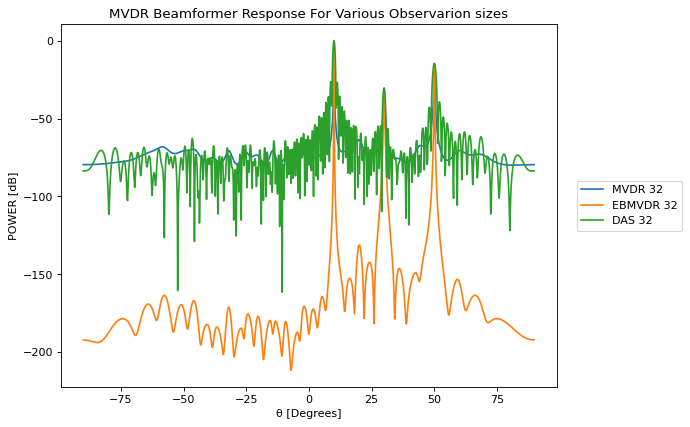

In [24]:
############################
###    Compare Models    ###
############################
Set_Overall_Seed()
M = 3
N = 128
nNumberOfSampels = 1
T = 1
SNR = 10

fig = plt.figure(figsize=(8, 6), dpi=80)
plt.title("MVDR Beamformer Response For Various Observarion sizes")
plt.xlabel("θ [Degrees]")
plt.ylabel("POWER [dB]")
div_List = [4]
for div in div_List:
  Set_Overall_Seed()
  DataSet_x, Sys_Model = CreateDataSet(
                          scenario= "NarrowBand",
                          mode= "non-coherent",
                          N = N, M= M , T= T,
                          Sampels_size = nNumberOfSampels,
                          Save = False,
                          DataSet_path = Main_Foldar + r"DataSet",
                          True_DOA = [10, 30, 50],
                          # True_DOA = [35],
                          SNR = SNR)
    
  ## Transform model-based test dataset into DataLoader Object:
  DataSetModelBased = torch.utils.data.DataLoader(DataSet_x,
                          batch_size = 1,
                          shuffle = False,
                          drop_last = False)

  ## Compute MUSIC and Root-MUSIC algorithms overall loss:
  model_based_platform = Model_Based_methods(Sys_Model)
  for i,data in enumerate(DataSetModelBased):
      X, Y = data
      X_modelbased = np.array(X[0])

      ## MVDR estimation
      MVDR_Response, MVDR_DOA_targets_pred = model_based_platform.SpatialSmooth_MVDR(X_modelbased, SubArraySize = int(N / div), eps = 0)
      plt.plot(model_based_platform.angels *180 / np.pi, 20 * np.log10(MVDR_Response / np.max(MVDR_Response)), label = "MVDR {}".format(int(N / div)))
      print("MVDR Source diraction: ", model_based_platform.angels[MVDR_DOA_targets_pred][:M + 1] * 180 / np.pi)

      ## EigenBasedMVDR estimation
      EBMVDR_Response, EBMVDR_DOA_targets_pred = model_based_platform.SpatialSmoothEigenBased_MVDR(X_modelbased, SubArraySize = int(N / div), eps = 0)
      plt.plot(model_based_platform.angels *180 / np.pi, 20 * np.log10(EBMVDR_Response / np.max(EBMVDR_Response)), label = "EBMVDR {}".format(int(N / div)))
      print("EigenBased MVDR Source diraction: ", model_based_platform.angels[EBMVDR_DOA_targets_pred][:M + 1] * 180 / np.pi)

      ## DAS estimation
      DAS_Response, DAS_DOA_targets_pred = model_based_platform.DAS(X_modelbased)
      plt.plot(model_based_platform.angels *180 / np.pi, 20 * np.log10(DAS_Response / np.max(DAS_Response)), label = "DAS {}".format(int(N / div)))
      print("DAS Source diraction: ", model_based_platform.angels[DAS_DOA_targets_pred][:M + 1] * 180 / np.pi)

plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
plt.show()

## Models

### ABLE

In [26]:
class ABLE(nn.Module):
    def __init__(self, System_model):
        super(ABLE, self).__init__()
        self.fc1 = nn.Linear(self.N, self.N)
        self.fc2 = nn.Linear(2* N, N / 4)
        self.fc3 = nn.Linear(N / 2, N / 4)
        self.fc3 = nn.Linear(N / 2, N)
        self.DropOut = nn.Dropout(0.2)
        self.Relu = nn.ReLU()
        self.angels = np.linspace(-1 * np.pi / 2, np.pi / 2, 1080, endpoint=False)                        # angle axis for represantation of the MUSIC spectrum
        self.system_model = System_model

    def AntiRectifier(self, X):
      meu = torch.mean(X)
      norm_ava_X = (X - meu) / torch.linalg.norm(X - meu)
      return torch.cat((self.Relu(norm_ava_X), self.Relu(-norm_ava_X)))
    
    def Deep_BF_ResponseCurve(self, W_opt, f=1, Array_form="ULA"):
      Response_Curve = []
      for angle in self.angels:
          a = self.system_model.SV_Creation(theta = angle, f= f, Array_form = Array_form)
          Response_Curve.append(np.conj(a).T @ W_opt @ np.conj(W_opt).T @ a)
      Response_Curve = np.array(Response_Curve, dtype=np.complex)
      return Response_Curve, 1 / Response_Curve
    
    def forward(self, X):
        ## Input shape of signal X(t): [Batch size, N, T]
        self.N = X.shape[1]
        # self.BATCH_SIZE = New_Rx_tau.shape[0]

        ## ABLE Archtecture
        W = self.DropOut(self.AntiRectifier(self.fc1(X)))
        W = self.DropOut(self.AntiRectifier(self.fc2(W)))
        W = self.DropOut(self.AntiRectifier(self.fc3(W)))
        W = self.fc4(W)

        ## Beamformer Response
        Response, _ = self.BF_ResponseCurve(W, f=1, Array_form = "ULA")

        DOA_targets_pred, _ = scipy.signal.find_peaks(Response)                        
        DOA_targets_pred = list(DOA_targets_pred)
        DOA_targets_pred.sort(key = lambda x: Response[x], reverse = True)

        DOA_jammers_pred, _ = scipy.signal.find_peaks(Opposite_response)                        
        DOA_jammers_pred = list(DOA_jammers_pred)
        DOA_jammers_pred.sort(key = lambda x: Opposite_response[x], reverse = True)
        return Response, DOA_jammers_pred, Opposite_response, DOA_targets_pred  

## Run Simulation Function

In [28]:
# saving_path = r"/content/drive/MyDrive/Thesis/DeepRootMUSIC/Code/Weights/Models"
saving_path = r"/content/drive/MyDrive/Code/Python/ulrasound_beamforming/Models"
# saving_path = r"Z:\Deep RootMUSIC\Models"
# saving_path = r"C:\Users\dorsh\OneDrive\שולחן העבודה\לימודים\תואר שני\תזה\Deep RootMUSIC\Models"

def Run_Simulation(Model_Train_DataSet,
                    Model_Test_DataSet,
                    tau, N, optimizer_name, lr_val, Schedular,
                    weight_decay_val, step_size_val, gamma_val, num_epochs,
                    model_name,
                    Bsize,
                    Sys_Model,
                    ActivationVal = 0.5,
                    checkpoint_optimizer_path = None,
                    load_flag = False, loading_path = None,
                    Plot = True, DataSetModelBased = None,
                    Plot_Spectrum_flag = False):
  
    ## Set the seed for all available random operations
    Set_Overall_Seed()
    
    ## Current date and time
    print("\n--- New Simulation ---\n")
    now = datetime.now()
    dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
    dt_string_for_save = now.strftime("%d_%m_%Y_%H_%M")
    print("date and time =", dt_string)

    ############################
    ### Model initialization ###
    ############################

    # Create a model from `Deep_Root_Net`
    model = Deep_Root_Net(tau=tau, ActivationVal=ActivationVal)                              
    
    # Load it to the specified device, either gpu or cpu
    model = model.to(device)                                   
    
    ## Loading available model
    if load_flag == True:
      if torch.cuda.is_available() == False:
        model.load_state_dict(torch.load(loading_path, map_location=torch.device('cpu')))
        print("CPU")
      else:
        model.load_state_dict(torch.load(loading_path))
      print("Loaded Succesfully")
    
    ## Create an optimizer 
    if optimizer_name == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=lr_val,weight_decay=weight_decay_val)
    elif optimizer_name == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=lr_val)
    elif optimizer_name == "SGD Momentum":
        optimizer = optim.SGD(model.parameters(), lr=lr_val, momentum=0.9)
    if Schedular:
        lr_decay = lr_scheduler.StepLR(optimizer, step_size=step_size_val, gamma=gamma_val)

    ## Loss criterion
    criterion = PRMSELoss()                                     # Periodic rmse loss

    ############################
    ###  Data Organization   ###
    ############################

    ## Split data into Train and Validation
    Train_DataSet, Valid_DataSet = train_test_split(Model_Train_DataSet, test_size=0.2, shuffle = True)
    print("Training DataSet size", len(Train_DataSet))
    print("Validation DataSet size", len(Valid_DataSet))

    ## Transform Training Datasets into DataLoader Object    
    Train_data = torch.utils.data.DataLoader(Train_DataSet,
                                    batch_size=Bsize,
                                    shuffle=True,
                                    drop_last=False)  
    Valid_data = torch.utils.data.DataLoader(Valid_DataSet,
                                    batch_size=1,
                                    shuffle=False,
                                    drop_last=False)
    
    ## Transform Test Dataset into DataLoader Object
    print("Test_DataSet", len(Model_Test_DataSet))
    Test_data = torch.utils.data.DataLoader(Model_Test_DataSet,
                                    batch_size=1,
                                    shuffle=False,
                                    drop_last=False)
    
    ############################
    ###     Train Model      ###
    ############################

    ## Train using the "train_model" function
    model, loss_train_list, loss_valid_list = train_model(model, Train_data, Valid_data,
                 optimizer, criterion, epochs= num_epochs, model_name=model_name, scheduler=lr_decay,
                    checkpoint_path=r"C:\Users\dorsh\OneDrive\שולחן העבודה\לימודים\תואר שני\תזה\Deep RootMUSIC\Weights" + '\ckpt-{}.pk')
    
    ## Save model Best weights
    torch.save(model.state_dict(), saving_path + '//' +  model_name + dt_string_for_save)
    
    ############################
    ###    Evaluate Model    ###
    ############################
    print("\n--- Evaluating Stage ---\n")
    ## Plot learning and validation loss curves
    if Plot:
      plot_learning_curve(list(range(num_epochs)), loss_train_list, loss_valid_list)

    ## Compute the model Overall loss
    DeepRootTest_loss = evaluate_model(model, Test_data, criterion)
    print("Deep Root-MUSIC Test loss = {}".format(DeepRootTest_loss))

    
    ############################
    ###    Compare Models    ###
    ############################

    ## Transform model-based test dataset into DataLoader Object:
    if DataSetModelBased != None:
      print("Test_DataSet", len(Model_Test_DataSet))
      DataSetModelBased = torch.utils.data.DataLoader(DataSetModelBased,
                                batch_size=1,
                                shuffle=False,
                                drop_last=False)
      
    ## Compute MUSIC and Root-MUSIC algorithms overall loss:
      RootMUSIC_loss, MUSIC_loss = evaluate_model_based(DataSetModelBased, Sys_Model)
      print("Root-MUSIC Test loss = {}".format(RootMUSIC_loss))
      print("MUSIC Test loss = {}".format(MUSIC_loss))

    ############################
    ###   Model's spectrum   ###
    ############################
    if Plot_Spectrum_flag:
      PlotSpectrum(model)
    
    return model, loss_train_list, loss_valid_list, DeepRootTest_loss


## Train model Function

In [29]:
def train_model(model, Train_data, Valid_data,
                 optimizer, criterion, epochs,
                 model_name, scheduler=None, checkpoint_path=None):
    PRINT_WEIGHTS = False
    since = time.time()
    loss_train_list = []
    loss_valid_list = []
    min_valid_loss = np.inf
    print("\n---Start Training Stage ---\n")

    for epoch in tqdm(range(epochs)):
        ## Train the model for a specific epoch
        train_length = 0
        model.train()
        Overall_train_loss = 0.0
        model = model.to(device)
        
        for i, data in enumerate(Train_data):
            Rx, DOA = data
            # print("DOA.shape", DOA.shape)
            train_length += DOA.shape[0]
            Rx = Variable(Rx, requires_grad=True).to(device)
            DOA = Variable(DOA, requires_grad=True).to(device)
            
            ## Compute model DOA predictions  
            model_parameters = model(Rx, DOA.shape[1])
                                        
            # DOA_predictions = model_parameters
            DOA_predictions = model_parameters[0]

            ## Compute training loss
            train_loss = criterion(DOA_predictions, DOA)

            ## Backpropogation stage
            try:                         
              train_loss.backward()
              # print("loss updated")
            except RuntimeError:
              print("linalg error")
              pass

            ## perform parameter update
            optimizer.step()                                                     
            
            model.zero_grad()                                                   # reset the gradients back to zero
            Overall_train_loss += train_loss.item()                             # add the batch training loss to epoch loss

            # print("iteration loss : ",train_loss.item())
            # if i % 50 == 0:
            #   print("Iteration = {}, accumulated loss= {}".format(i+1, Overall_train_loss / (i+1)))
            
            if PRINT_WEIGHTS:
              for name, param in model.named_parameters():
                if param.grad is not None:
                  print(name, param.grad.sum())
                else:
                  print(name, param.grad)
        # print("len(Train_data)", len(Train_data))
        # print("Overall_train_loss = {}, train_length = {}".format(Overall_train_loss, train_length))
        Overall_train_loss = Overall_train_loss / train_length               # compute the epoch training loss
        loss_train_list.append(Overall_train_loss)
        if scheduler != None:
            scheduler.step()
        ## Evaluate the model for a specific epoch
        Overall_valid_loss = 0.0
        model.eval()
        valid_length = 0
        
        with torch.no_grad():                                                   # Gradients Calculation isnt required for evaluation
            for i, data in enumerate(Valid_data):
                Rx, DOA = data
                valid_length += DOA.shape[0]
                Rx = Rx.to(device)
                DOA = DOA.to(device)
                model_parameters = model(Rx, DOA.shape[1])                            # Compute prediction of DOA's
                DOA_predictions = model_parameters[0]
                # DOA_predictions = model_parameters
                eval_loss = criterion(DOA_predictions, DOA)                     # Compute evaluation predictions loss
                Overall_valid_loss += eval_loss.item()                          # add the batch evaluation loss to epoch loss
            
            Overall_valid_loss = Overall_valid_loss / valid_length
            loss_valid_list.append(Overall_valid_loss)
        
        ## Report results
        print("epoch : {}/{}, Train loss = {:.6f}, Validation loss = {:.6f}".format(epoch + 1,
                         epochs, Overall_train_loss, Overall_valid_loss))                       # display the epoch training loss
        print('lr {}'.format(optimizer.param_groups[0]['lr']))
        
        ## save model weights for better validation performences
        if min_valid_loss > Overall_valid_loss:
            print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{Overall_valid_loss:.6f}) \t Saving The Model')
            min_valid_loss = Overall_valid_loss
            best_epoch = epoch
            ## Saving State Dict
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), saving_path + '//' +  model_name)
    
    time_elapsed = time.time() - since
    # plot_learning_curve(list(range(epochs)),
    #                     loss_train_list, loss_valid_list)
    print("\n--- Training summary ---")
    print('Training complete in {:.0f}m {:.0f}s'.format( time_elapsed // 60, time_elapsed % 60))
    print('Minimal Validation loss: {:4f} at epoch {}'.format(min_valid_loss, best_epoch))

    # load best model weights
    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), saving_path + '//' +  model_name)
    return model, loss_train_list, loss_valid_list

def plot_learning_curve(epoch_list, train_loss, Validation_loss):
    """
    Plot the learning curve.
    """
    plt.title("Learning Curve: Loss per Epoch")
    plt.plot(epoch_list, train_loss, label="Train")
    plt.plot(epoch_list, Validation_loss, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

def evaluate_model(model, Data, criterion):
    loss = 0.0
    model.eval()
    test_length = 0
    with torch.no_grad():                                                                   # Gradients Calculation isnt required for evaluation
        for i, data in enumerate(Data):
            Rx, DOA = data
            test_length += DOA.shape[0]
            Rx = Rx.to(device)
            DOA = DOA.to(device)
            model_parameters = model(Rx, DOA.shape[1])                            # Compute prediction of DOA's
            # DOA_predictions = model_parameters
            DOA_predictions = model_parameters[0]
            eval_loss = criterion(DOA_predictions, DOA)                                     # Compute evaluation predictions loss
            loss += eval_loss.item()                                          # add the batch evaluation loss to epoch loss
        # print(len(Data))    
        loss = loss / test_length
    return loss

### Evaluation for Model-based methods

In [30]:
def PRMSE(pred, DOA):
  prmse_list = []
  for p in list(permutations(pred, len(pred))):
      p = np.array(p)
      DOA = np.array(DOA)
      error = (((p - DOA) * np.pi / 180) + np.pi / 2) % np.pi - np.pi / 2
      prmse_val = (1 / np.sqrt(len(p))) * np.linalg.norm(error)
      prmse_list.append(prmse_val)
  return np.min(prmse_list)

def evaluate_model_based(DataSetModelBased, Sys_Model):
  RootMUSIC_list = []
  MUSIC_list = []
  DeepRootMUSIC_list = []
  model_based_platform = Model_Based_methods(Sys_Model)
  for i,data in enumerate(DataSetModelBased):
      X, Y = data
      X_modelbased = X[0]
      ## RootMUSIC predictions
      DOA_pred_RootMUSIC, roots, M, DOA_pred_all, roots_angels_all = model_based_platform.Classic_Root_MUSIC(X_modelbased, NUM_OF_SOURCES=True)
      
      if(DOA_pred_RootMUSIC.shape[0] < M):
        print("Cant estimate M sources")
      else:
        lossRootMUSIC = PRMSE(DOA_pred_RootMUSIC, Y * 180 / np.pi)
        RootMUSIC_list.append(lossRootMUSIC)
      
      ## MUSIC predictions
      DOA_pred_MUSIC, Spectrum, M = model_based_platform.Classic_MUSIC(X_modelbased, NUM_OF_SOURCES=M)
      DOA_pred = model_based_platform.angels[DOA_pred_MUSIC] * 180 / np.pi                                   # Convert from Radians to Deegres
      predicted_DOA = DOA_pred[:M][::-1]
      if(predicted_DOA.shape[0] < M):
        print("Cant estimate M sources")
      else:
        lossMUSIC = PRMSE(predicted_DOA, Y * 180 / np.pi)
        MUSIC_list.append(lossMUSIC)
  return np.mean(RootMUSIC_list), np.mean(MUSIC_list)

coherent sources with gap above 0.2 [rad]

#### M=3 simulation

In [31]:
############################
###    Load Data Sets    ###
############################

Data_Set_path = r"/content/drive/MyDrive/Thesis/DeepRootMUSIC/Code/DataSet"
tau = 8
N = 8
M = 3
T = 100
nNumberOfSampels = 55000
scenario = "NarrowBand"
mode = "coherent"
train_details_line = '_{}_{}_{}_M={}_N={}_T={}.h5'.format(scenario, mode, nNumberOfSampels, M, N, T)
test_details_line = '_{}_{}_{}_M={}_N={}_T={}.h5'.format(scenario, mode, int(0.2 * nNumberOfSampels), M, N, T)

DataSet_Rx_train = Read_Data(Data_Set_path + r"/CoherentSourcesWithGap/TrainingData/DataSet_Rx" + train_details_line)
DataSet_Rx_test = Read_Data(Data_Set_path + r"/CoherentSourcesWithGap/TestData/DataSet_Rx" + test_details_line)
DataSet_x_test = Read_Data(Data_Set_path + r"/CoherentSourcesWithGap/TestData/DataSet_x" + test_details_line)
Sys_Model = Read_Data(Data_Set_path + r"/CoherentSourcesWithGap/TestData/Sys_Model" + test_details_line)

############################
## Simulation  parameters ##
############################

optimal_gamma_val = 1
optimal_BS = 2040
lr_list = [0.001, 1e-5]
optimal_step = 60
epochs = 30

############################
###    Run Simulations   ###
############################

Test_losses = []
train_loss_lists = []
validation_loss_lists = []

train_curves = []
validation_curves = []

fig = plt.figure(figsize=(8, 6), dpi=80)
for lr in lr_list:
  print("learning Rate Value = {}".format(lr))
  model, loss_train_list, loss_valid_list, Test_loss = Run_Simulation(
                Model_Train_DataSet = DataSet_Rx_train,
                Model_Test_DataSet = DataSet_Rx_test,
                tau = tau,
                N = N,
                optimizer_name = "Adam",
                lr_val = lr,
                Schedular = True,
                weight_decay_val = 1e-9,
                step_size_val = optimal_step,
                gamma_val = optimal_gamma_val,
                num_epochs = epochs,
                model_name="model_tau=8_M=2_50Ksampels_coherent_sources",
                Bsize = optimal_BS,
                Sys_Model = Sys_Model,
                load_flag = True,
                loading_path = r"/content/drive/MyDrive/Thesis/DeepRootMUSIC/Code/Weights/Models/model_tau=8_M=2_50Ksampels_coherent_sources13_05_2022_15_26",
                Plot = False,
                DataSetModelBased = DataSet_x_test)
  
  train_loss_lists.append(loss_train_list)
  torch.save(torch.tensor(loss_train_list), r"/content/drive/MyDrive/Thesis/DeepRootMUSIC/Code/Simulations/lr_sim" +
                                             '/' + str(optimal_BS) + "_train_loss_curve_" + str(lr))

  validation_loss_lists.append(loss_valid_list)
  torch.save(torch.tensor(loss_valid_list), r"/content/drive/MyDrive/Thesis/DeepRootMUSIC/Code/Simulations/lr_sim" +
                                             '/' + str(optimal_BS) + "_validation_loss_curve_" + str(lr))
  
  Test_losses.append(Test_loss)
  torch.save(torch.tensor(Test_loss), r"/content/drive/MyDrive/Thesis/DeepRootMUSIC/Code/Simulations"  +
                                       '/' + str(optimal_BS) +  "_Test_loss_curve_" + str(lr))
  
  plt.plot(range(epochs), loss_train_list, label="tr {}".format(lr))
  plt.plot(range(epochs), loss_valid_list, label="vl {}".format(lr))

plt.title("Learning Curves: Loss per Epoch - different Learning Rates")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
plt.show()

FileNotFoundError: ignored